In [1]:
import numpy as np
from matplotlib import pyplot as plt
from SERSGenerator import SERSGenerator, pseudo_voigt

from tqdm import tqdm
from scipy.special import erfc, erfcinv
from scipy.stats import norm

from sklearn.decomposition import NMF
from matplotlib.ticker import MultipleLocator

In [2]:
def plot_map(gen, X, figsize=(8,8)):
    fig, axs = plt.subplots(2,2, figsize=figsize)

    # SERS Matrix
    axs[0,0].imshow(X, cmap='viridis', interpolation='none')
    axs[0,0].set_xlabel('Wavenumber')
    axs[0,0].set_ylabel('Spectrum index')
    axs[0,0].set_title('X')
    axs[0,0].grid(False)

    # Map at peak 1
    mappable = axs[0,1].imshow(X[:, int(round(gen.c[0]))].reshape(*gen.mapsize), cmap='viridis', interpolation='none')
    axs[0,1].set_title(f'c={round(gen.c[0])}')
    axs[0,1].grid(False)
    plt.colorbar(mappable=mappable, ax=axs[0,1])

    # One spectrum
    axs[1,0].plot(X[np.argmax(X)//gen.Nw,:])
    axs[1,0].set_xlabel('Wavenumber')
    axs[1,0].set_title('Highest spectrum')

    # Pure Voigt of peak 1
    axs[1,1].plot(gen.Vp[0,:])
    axs[1,1].set_xlabel('Wavenumber')
    axs[1,1].set_title('Pure Voigt 1')

    fig.tight_layout()
    plt.show()

# Non-negative matrix factorization

The NMF approach to modeling spectroscopy data assumes that each observed spectrum can be decomposed as a weighted sum of constituent basis spectra. Using a Normal observation noise model

$$ X_{w,n} | S,A,\tau  \sim \mathcal{N}([SA]_{w,n}, \tau^{-1}), $$

where $\tau$ is the noise precision, the data array is modeled as product of two matrices, $S$ and $A$, where $K$ columns of $S$ are the basis spectra, and each column of $A$ contain their amplitudes for a given observation spectrum.

We assume a standard conjugate Gamma prior for the noise precision precision,

$$ \tau \sim Gamma(a_{\tau_0}, b_{\tau_0}) $$

with shape $a_{\tau_0}$ and rate $b_{\tau_0}$. We use independant exponential priors for both the spectra and their amplitudes,

$$ A_{k,n} \sim^{iid} Exp(A_0), \:\:\:\: S_{k,n} \sim^{iid} Exp(S_0)$$

with rates $A_0$ and $S_0$ respectively. These priors reflect the constraints that the spectra and their amplitudes are non-negative and correpond to a Bayesian sparse NMF model.

[see *A pseudo-Voigt component model for high-resolution recovery of constituent spectra in Raman spectroscopy*]

In [3]:
def draw_rectified_normal(mu, sigma, lamda, size):
    samples = np.random.normal(mu, sigma, size)
    rectified_samples = samples[samples >= 0]
    weights = np.exp(-(rectified_samples - mu) ** 2 / (sigma ** 2) - lamda * rectified_samples)
    normalized_weights = weights / np.sum(weights)
    return np.random.choice(rectified_samples, size=size, p=normalized_weights)

In [4]:
def randr(m, s, l):
    """ Draw random numbers from rectified normal density
    p(x)=K*exp(-(x-m)^2/s-l'x), x>=0 

    Input:

    m           Means  (N,)
    s           Variance
    l           Scales (N,)
    Output:
    x           Random numbers sampled (N,)

    Copyright 2007 Mikkel N. Schmidt, ms@it.dk, www.mikkelschmidt.dk
    """
    A = (l * s - m) / np.sqrt(2 * s)
    a = A > 26
    x = np.zeros_like(m)

    y = np.random.rand(*m.shape)
    x[a] = -np.log(y[a]) / ((l[a] * s - m[a]) / s)

    R = erfc(np.abs(A[~a]))
    x[~a] = erfcinv(y[~a] * R - (A[~a] < 0) * (2 * y[~a] + R - 2)) * np.sqrt(2 * s) + m[~a] - l[~a] * s

    x[np.isnan(x)] = 0
    x[x < 0] = 0
    x[np.isinf(x)] = 0
    x = x.real

    return x

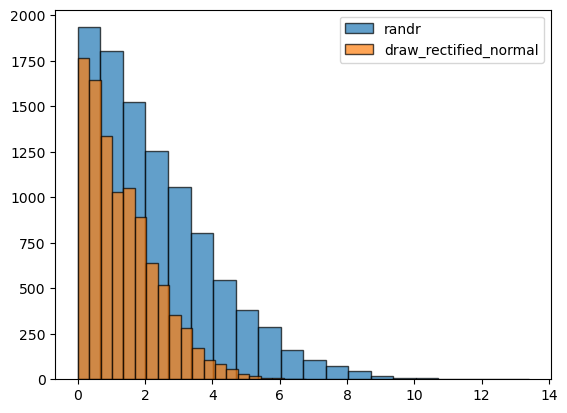

In [5]:
# Test function
Q = 10000
m = np.tile(np.random.rand(1,1), (Q,1))
s = 10
l = np.tile(np.random.rand(1,1), (Q,1))

yyy = draw_rectified_normal(m[0], s**(1/2), l[0], size=Q)
xxx = randr(m, s, l)

plt.hist(xxx, bins=20, ec='black', alpha=0.7, color='C0', label='randr')
plt.hist(yyy, bins=20, ec='black', alpha=0.7, color='C1', label='draw_rectified_normal')
plt.legend()
plt.show()

# Gibbs sampling NMF

In [6]:
from scipy.stats import norm, expon, invgamma

In [7]:
def nmf_gibbs(X, K, M, hyperparams):
    """ Non-negative matrix factorization Gibbs sampler

    Args:
        X       Data matrix (IxJ)
        K       Number of components (int>0)
        M       Number of Gibbs samples to compute (int>0)
        hyperparams: dictionary containing keys: 
            alpha   Prior scale for A (float > 0)     (Exp. distr.)
            beta    Prior scale for B (float > 0)     (Exp. distr.)
            theta   Prior scale for sigma squared (float > 0) (Gamma distr.)
            k       Prior shape for sigma squared (float > 0) (Gamma distr.)

    Returns:
        trace: dictionnary containing keys:
            As           Trace of samples of A (I x N x M)
            Bs           Trace of samples of B (N x J x M)
            sigma2s      Trace of samples of sigma squared (M)
    """
    I, J = X.shape

    # Transform input parameters
    alpha = hyperparams["alpha"]
    beta = hyperparams["beta"]
    theta = hyperparams["theta"]
    k = hyperparams["k"]
    
    alpha = alpha * np.ones((I,K))
    beta = beta * np.ones((K,J))
    
    # Initialization
    A = np.random.rand(I, K) #Initial value for A (I x N)
    B = np.random.rand(K, J) #Initial value for B (N x J)
    sigma2 = 0.05            #Initial value for noise variance (sigma^2)

    # Containers for all samples
    As = np.zeros((I, K, M))
    Bs = np.zeros((K, J, M))
    sigma2s = np.zeros((M,))
     
    # Loop over gibbs samples
    for m in tqdm(range(M)):
    
        # Sample A: Loop over columns of A
        C = B@B.T
        D = X@B.T
        for n in range(K):
            # all columns except n
            nn = np.concatenate((np.arange(n), np.arange(n+1, K)))

            # Sample from rectified normal distr.
            mu = (D[:, n] - (A[:, nn]@C[nn, n]) - (alpha[:,n]*sigma2)) / C[n, n]
            var = sigma2 / C[n, n]
            scale = alpha[:, n]
            A[:, n] = randr(mu, var, scale)

        # Sample sigma squared from inverse gamma distr.
        sigma2 = invgamma.rvs(a=(I*J)/2 + k + 1, loc=0, scale=0.5*np.sum((X-(A@B))**2)+theta)

        # Sample B: Loop over rows of B
        E = A.T@A
        F = A.T@X
        for n in range(K):
            # all rows except n
            nn = np.concatenate((np.arange(n), np.arange(n+1, K)))

            # Sample from rectified normal distr.
            mu = (F[n,:] - (E[n,nn]@B[nn,:]) - (beta[n,:]*sigma2)) / E[n,n] 
            var = sigma2 / E[n,n]
            scale = beta[n,:]
            B[n,:] = randr(mu, var, scale)
        
        # Traces
        As[:,:,m] = A 
        Bs[:,:,m] = B
        sigma2s[m] = sigma2

    return {"A":As,
            "B":Bs,
            "sigma2":sigma2s}

In [8]:
def compute_probabilities(X, trace, hyperparams, plot=True):
    As = trace["A"]
    Bs = trace["B"]
    sigma2s = trace["sigma2"]
    
    M = len(sigma2s)
    log_likelihood = np.zeros((M,))
    log_posterior = np.zeros((M,))
    log_prior_A = np.zeros((M,))
    log_prior_B = np.zeros((M,))
    log_prior_sigma2 = np.zeros((M,))
    
    # Loop over gibbs samples
    for m in tqdm(range(M)):
        
        A = As[:,:,m]
        B = Bs[:,:,m]
        sigma2 = sigma2s[m]
        
        # Log-Likelihood p(X|AB,sigma2)
        AB = A@B
        log_likelihood[m]  = np.sum(norm.logpdf(X, loc=AB, scale=sigma2**(1/2)))
        
        # Log-Priors
        log_prior_A[m] = np.sum(expon.logpdf(A, scale=1/hyperparams['alpha']))
        log_prior_B[m] = np.sum(expon.logpdf(B, scale=1/hyperparams['beta']))
        log_prior_sigma2[m] = invgamma.logpdf(sigma2, a=hyperparams['k'], scale=hyperparams['theta'])
                
        # Log-Posterior
        log_posterior[m] = log_likelihood[m] + log_prior_A[m] + log_prior_B[m] + log_prior_sigma2[m]
        
    if plot:
        fig, axes = plt.subplots(1,2, figsize=(15,5))
        axes[0].plot(log_likelihood, color='C0')
        axes[0].set(title='Log-likelihood')
        
        axes[1].plot(log_posterior, color='C1')
        axes[1].set(title='Log-Posterior')
        plt.show()
        
        
        
        fig, axes = plt.subplots(1,3, figsize=(15,5))
        axes[0].plot(log_prior_A, color='C2')
        axes[1].plot(log_prior_B, color='C5')
        axes[2].plot(log_prior_sigma2, color='C4')
        plt.show()
        
        
    return {'log_likelihood': log_likelihood,
            'log_posterior': log_posterior,
            'log_prior_A': log_prior_A,
            'log_prior_B': log_prior_B,
            'log_prior_sigma2': log_prior_sigma2}

In [9]:
def postprocess_gibbs(trace, burnin=0.25, plot=True):
    As = trace["A"]
    Bs = trace["B"]
    sigma2s = trace["sigma2"]
    
    K = As.shape[1]
    M = As.shape[2]
    
    # Burn-in: discard beginning samples
    start = int(burnin*M)
    As = As[:,:, start:]
    Bs = Bs[:,:, start:]
    sigma2s = sigma2s[start:]
    
    # Normalize for visualization
    maxB = np.max(np.mean(Bs,axis=2))
    As *= maxB
    Bs /= maxB
    
    # Aggregate samples
    A_mean = np.mean(As, axis=2)
    B_mean = np.mean(Bs, axis=2)
    B_perc5 = np.percentile(Bs, 5, axis=2)
    B_perc95 = np.percentile(Bs, 95, axis=2)
    
    if plot:
        for i in range(K):
            fig, ax = plt.subplots(figsize=(15,5))

            ax.plot(gen.Vp[0,:], label='True underlying signal', color='blue', ls='--')
            
            ax.plot(B_mean[i,:], color='red',  label='NMF (mean)')
            ax.fill_between(np.arange(W),B_perc5[i,:], B_perc95[i,:], alpha=0.2,
                            color='red', label='NMF (95% credibility interval)')

            ax.set(title="Component row {}".format(i+1))
            ax.set_xlim([0,W])
            ax.set_ylim([0,np.max(B_perc95)])
            plt.legend()
            plt.show()
        
        plt.boxplot(sigma2s)
        plt.title('Boxplot of $\sigma^2$')
        plt.show()
    
    return A_mean, B_mean

## Example

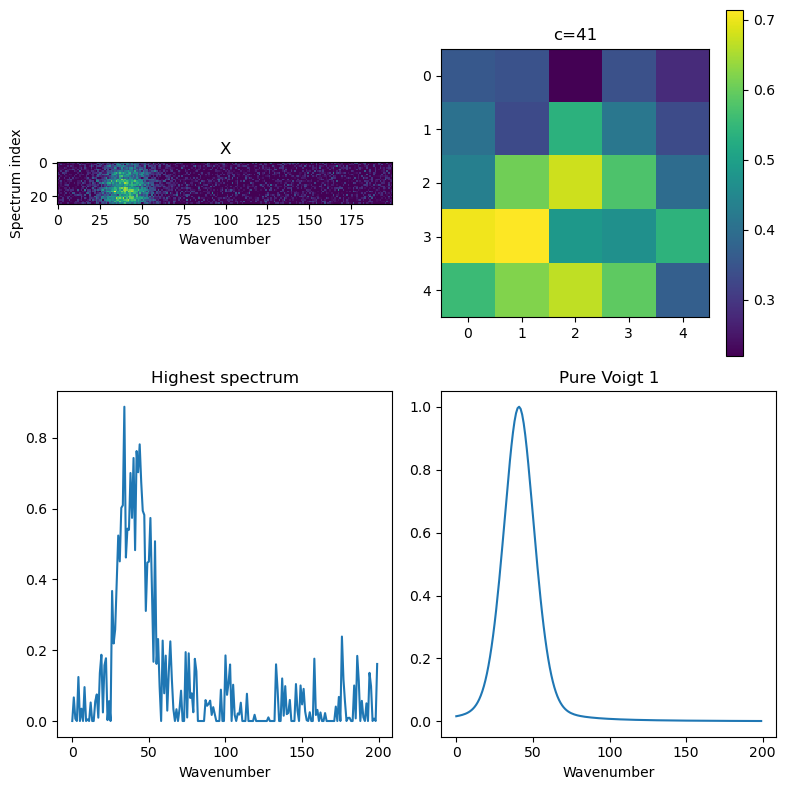

In [10]:
mapsize= (5,5)
N = mapsize[0]*mapsize[1]
W = 200

gen = SERSGenerator(mapsize=mapsize, Nw=W, seed=3, eta=0)
X = gen.generate(N_hotspots=2, K=1, sig=0.1, sbr=1, plot=False, background='none')
X = np.clip(X, 0, None)

plot_map(gen, X)

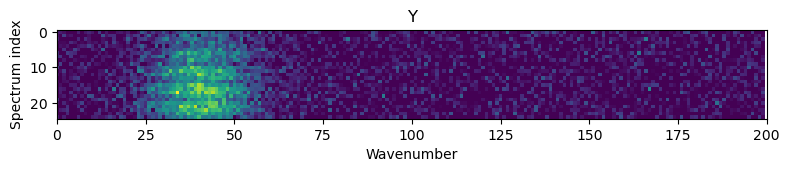

In [11]:
from utils.plot_map import plot_SERS

plot_SERS(X)

In [43]:
M = 5000
K = 1
hyperparams = {'alpha':10, 'beta':1, 'k':1, 'theta':1}
trace = nmf_gibbs(X, K, M, hyperparams)

100%|█████████████████████████████████████| 5000/5000 [00:01<00:00, 3000.86it/s]


100%|█████████████████████████████████████| 5000/5000 [00:03<00:00, 1480.80it/s]


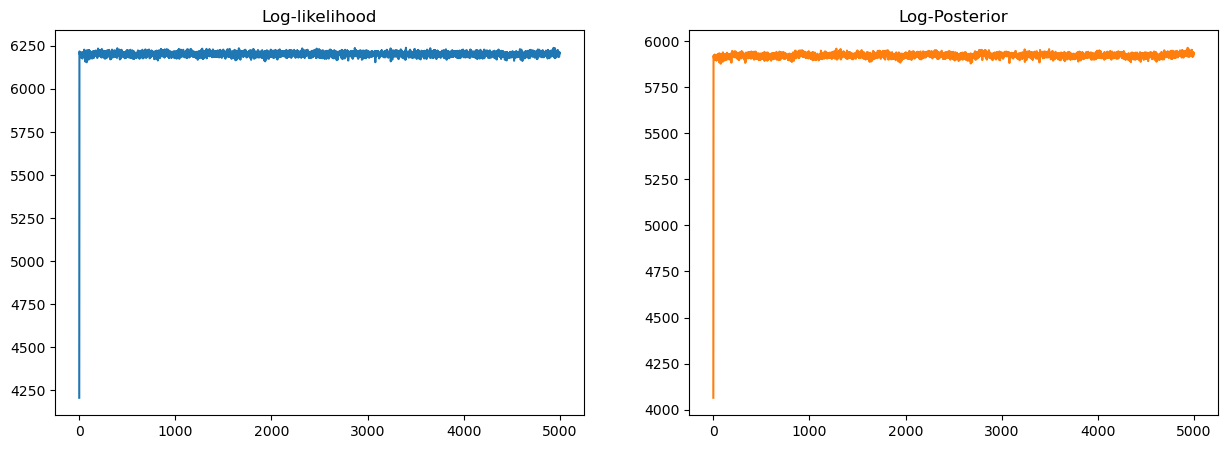

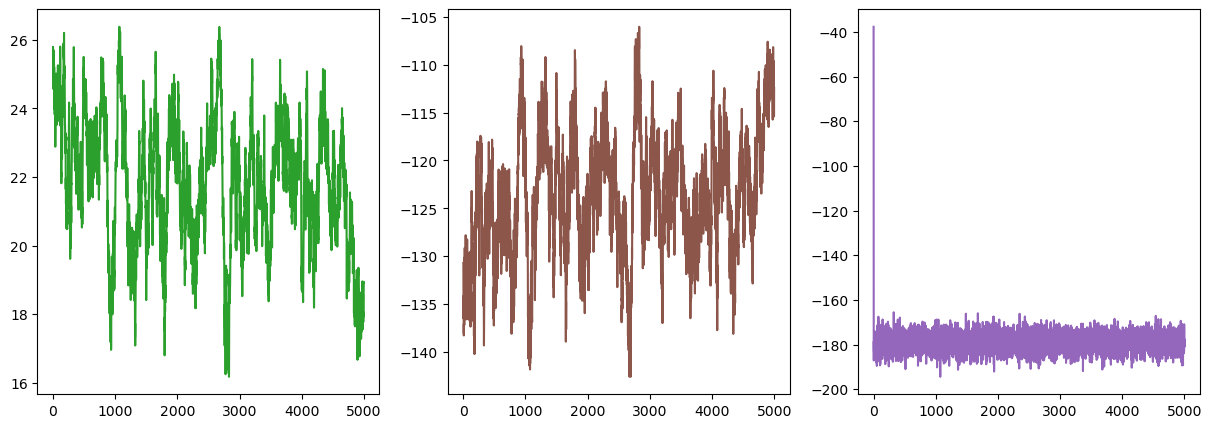

In [44]:
probs = compute_probabilities(X, trace, hyperparams)

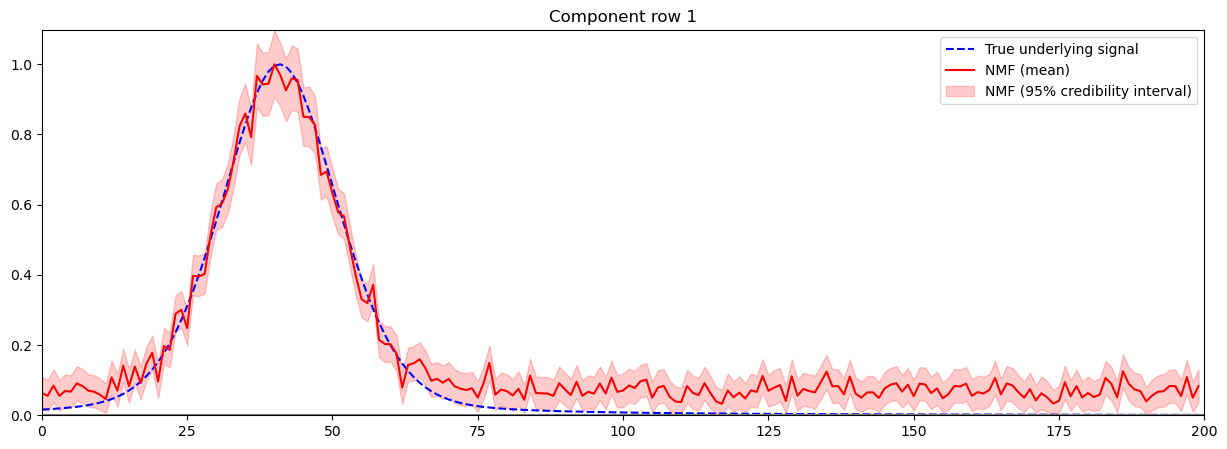

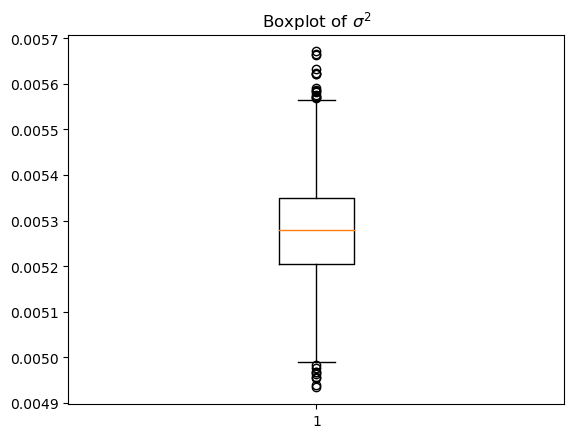

In [45]:
A_mean, B_mean = postprocess_gibbs(trace, burnin=0.25, plot=True)

## Traces

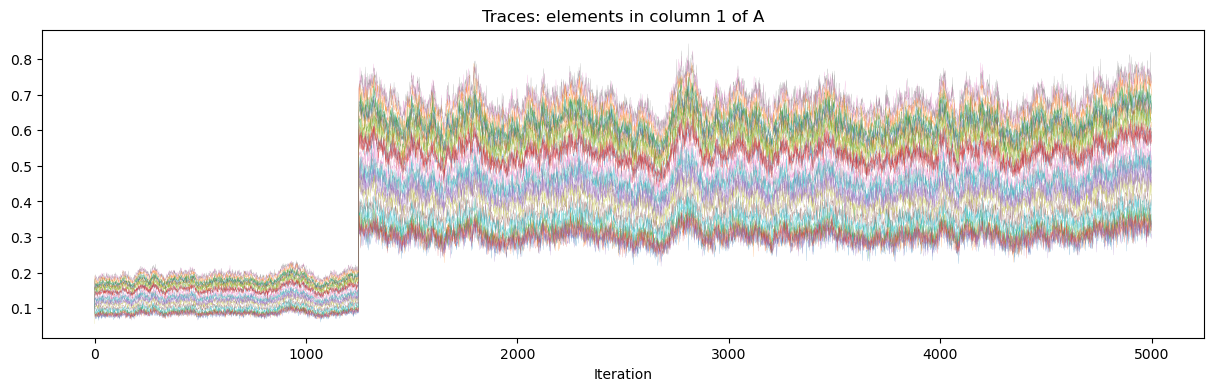

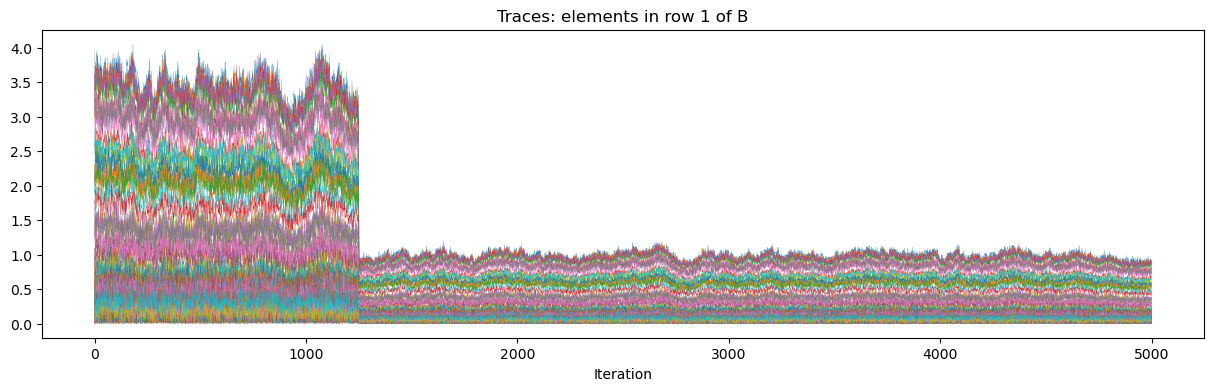

In [15]:
As = trace['A']
Bs = trace['B']
figsize = (15,4)
for k in range(K):
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(As.shape[0]):
        ax.plot(As[i,k,:], lw=0.1)
    ax.set(title='Traces: elements in column {} of A'.format(k+1),  xlabel='Iteration')
    plt.show()

for k in range(K):
    fig, ax = plt.subplots(figsize=figsize)
    for i in range(Bs.shape[1]):
        ax.plot(Bs[k,i,:], lw=0.2)
    ax.set(title='Traces: elements in row {} of B'.format(k+1),  xlabel='Iteration')
    plt.show()


## Reconstruction

In [16]:
X_reconstructed = A_mean@B_mean

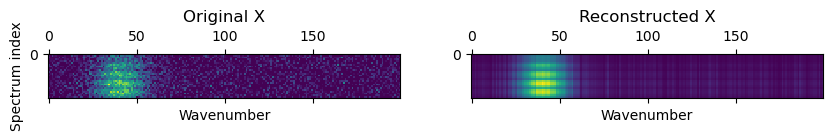

In [17]:
# Dataset Matrix
fig, axes = plt.subplots(1,2, figsize=(10,20))

# Original
ax = axes[0]
mappable = ax.matshow(X, cmap='viridis')
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Spectrum index')
ax.set_title('Original X')
ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.grid(which='major', axis='both')
#plt.colorbar(mappable=mappable, ax=ax)


# Reconstructed
ax = axes[1]
mappable = ax.matshow(X_reconstructed, cmap='viridis')
ax.set_xlabel('Wavenumber')
ax.set_title('Reconstructed X')
ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.grid(which='major', axis='both')
#plt.colorbar(mappable=mappable, ax=ax)

plt.show()

In [18]:
np.max(X), np.max(X_reconstructed)

(0.8883156794049734, 0.6919189112906616)

In [19]:
np.min(X), np.min(X_reconstructed)

(0.0, 0.00974000749079166)

In [20]:
def nmf_sklearn(X, K, plot=True):
    X_clipped = X.clip(min=0)
    nmf = NMF(n_components=K, max_iter=1000)
    S = nmf.fit_transform(X_clipped)
    A = nmf.components_
    
    if plot:
        for i in range(K):
            fig, ax = plt.subplots(figsize=(15,4))
    
            ax.plot(gen.Vp[0,:], color='orange', ls='--', label='True underlying signal')
            #ax.plot(gen.B[:], color='purple', ls='--', label='True underlying background signal')

            plt.plot(A[i,:], color='red', label='NMF', alpha=0.7)
            
            plt.axhline(y=0, color='grey')

            ax.set(title="Component row {}".format(i+1))
            ax.set_xlim([0,W])

            plt.legend()
            plt.show()
    
    return S, A

/Users/victor/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


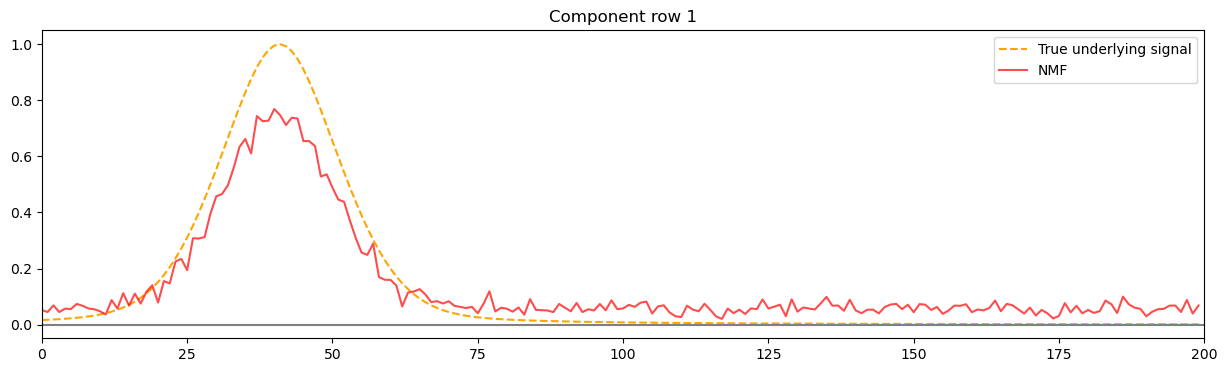

In [21]:
_, _ = nmf_sklearn(X, K=1, plot=True)

## K = 2

In [23]:
M = 5000
K = 2
trace2 = nmf_gibbs(X, K, M, hyperparams)

100%|█████████████████████████████████████| 5000/5000 [00:02<00:00, 1846.95it/s]


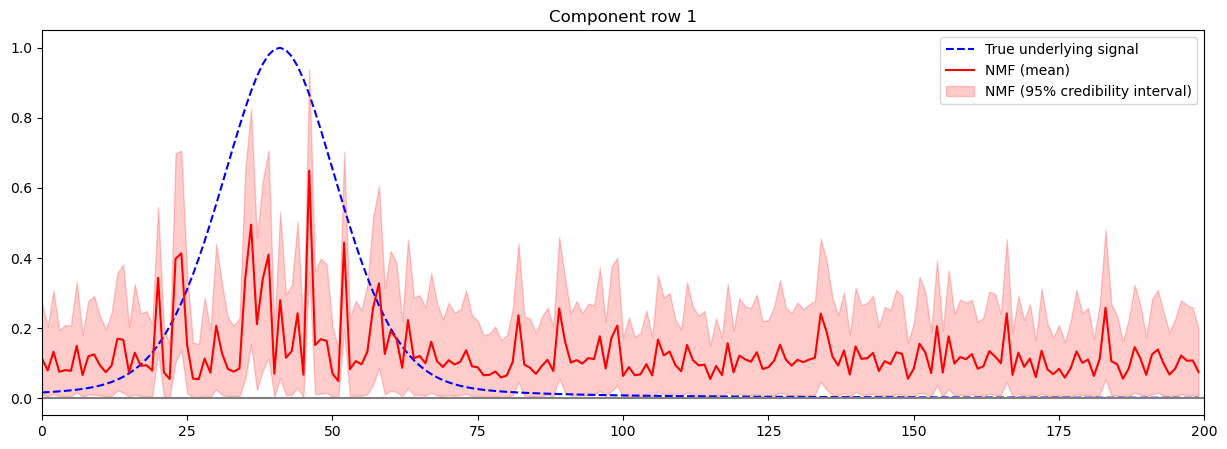

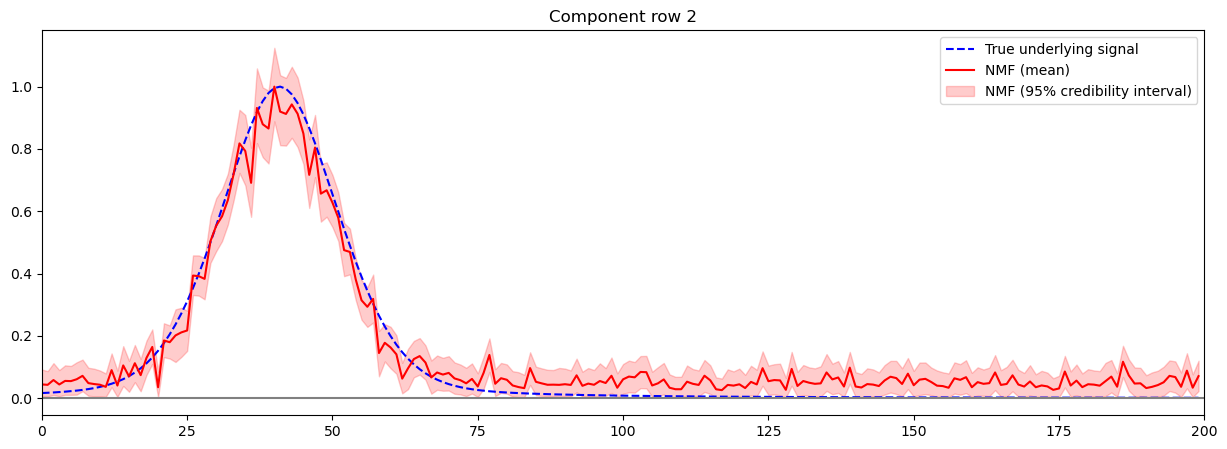

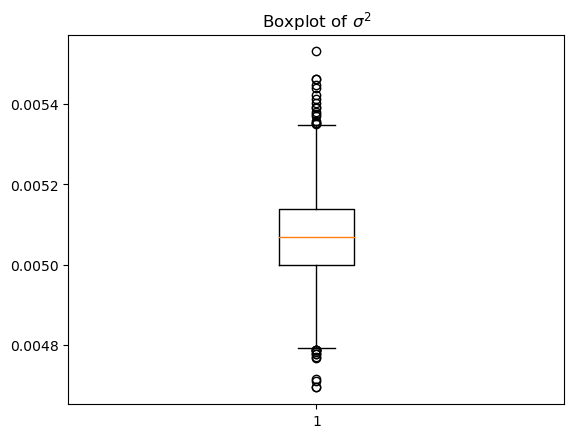

In [24]:
A_mean, B_mean = postprocess_gibbs(trace2, burnin=0.25, plot=True)

## With background noise

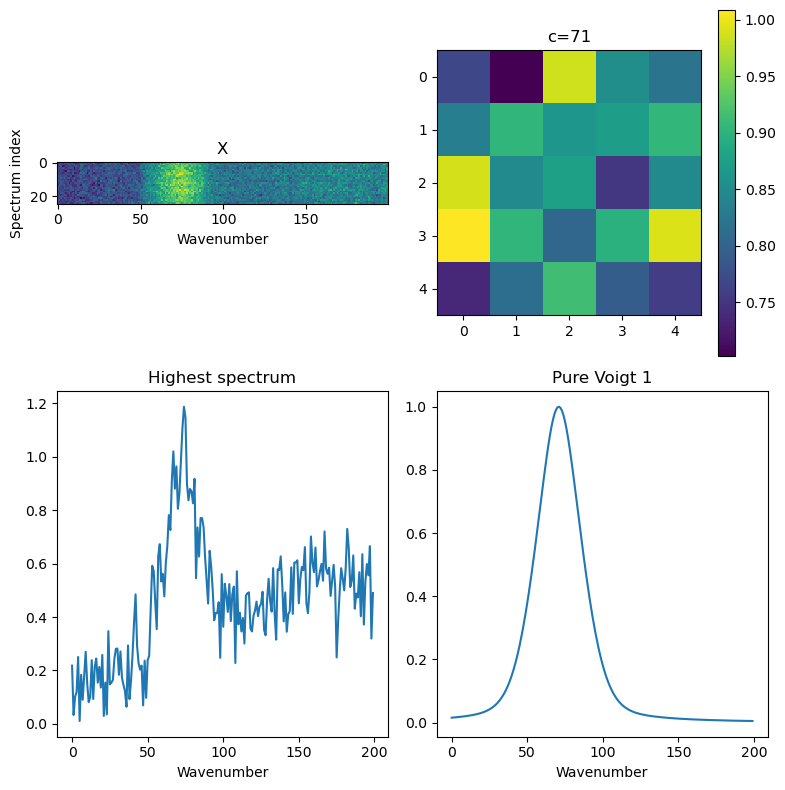

In [25]:
mapsize= (5,5)
N = mapsize[0]*mapsize[1]
W = 200

gen = SERSGenerator(mapsize=mapsize, Nw=W, seed=3, eta=0)
X = gen.generate(N_hotspots=2, K=1, sig=0.1, sbr=1, plot=False, background='default')

plot_map(gen, X)

/Users/victor/opt/anaconda3/envs/thesis/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
  warnings.warn(


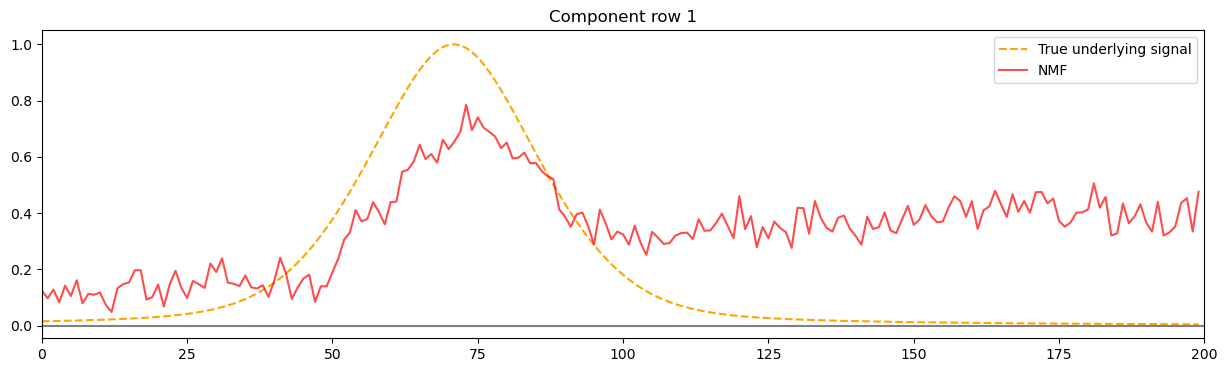

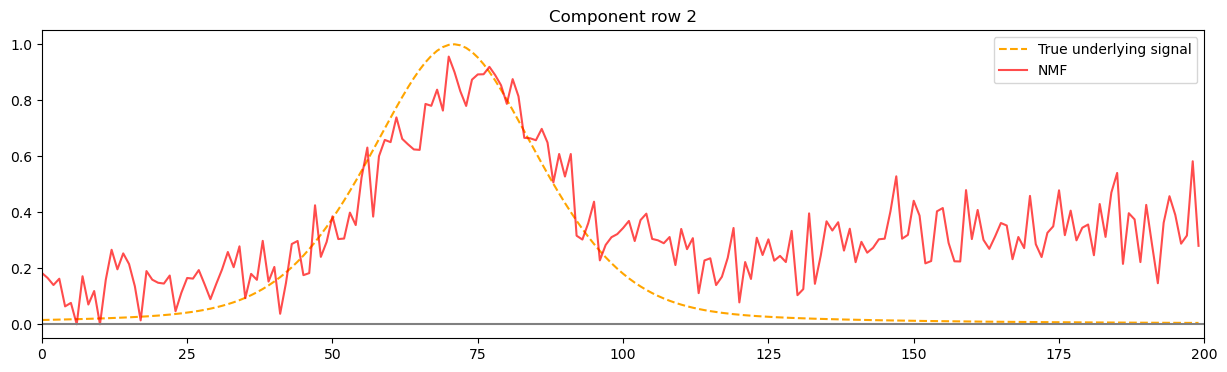

In [26]:
_, _ = nmf_sklearn(X, K=2, plot=True)

In [27]:
M = 10000
K = 2
trace3 = nmf_gibbs(X, K, M, hyperparams)

100%|███████████████████████████████████| 10000/10000 [00:05<00:00, 1813.72it/s]


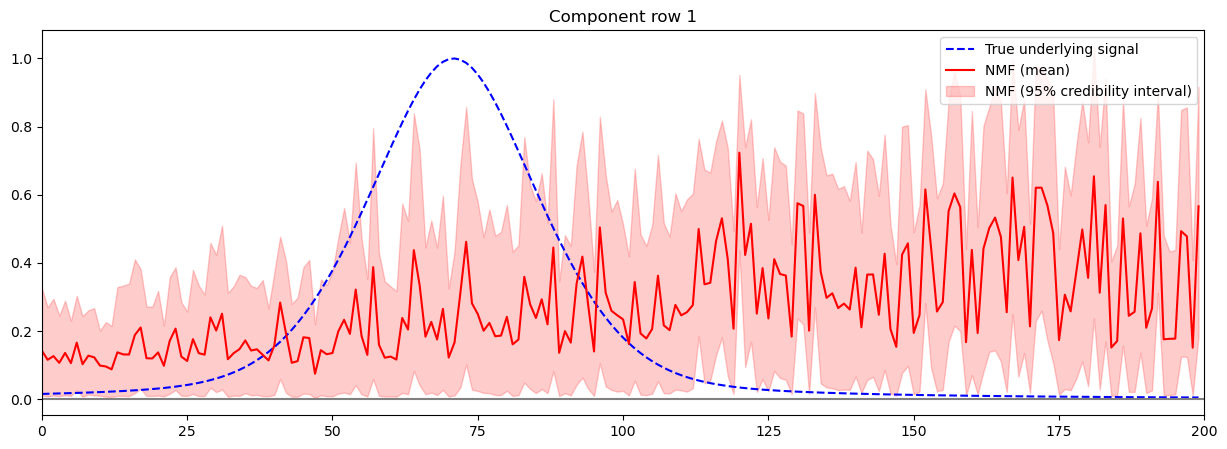

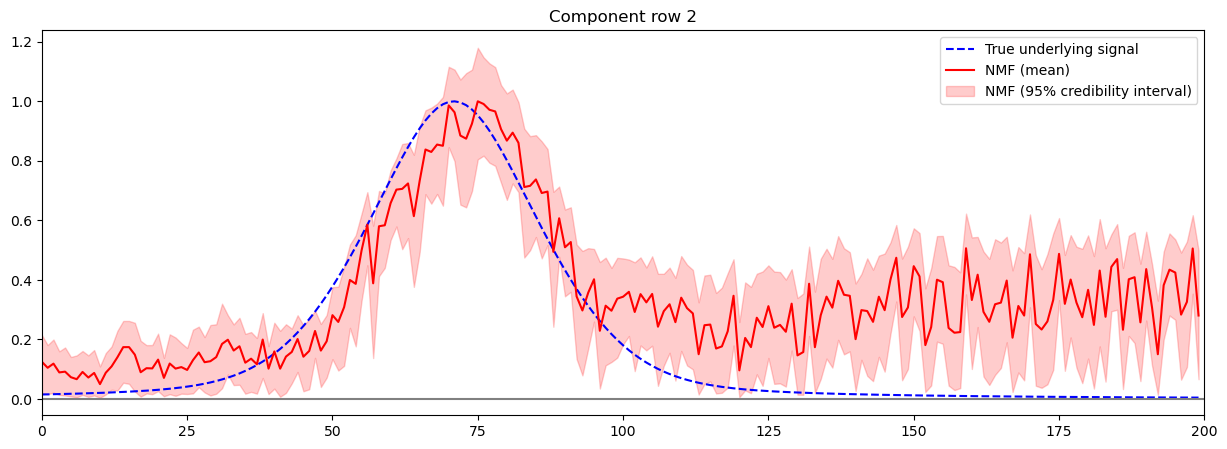

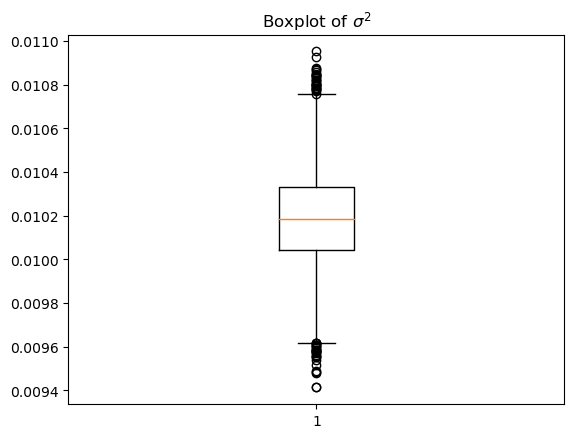

In [28]:
A_mean, B_mean = postprocess_gibbs(trace3, burnin=0.25, plot=True)

In [29]:
X_reconstructed = A_mean@B_mean

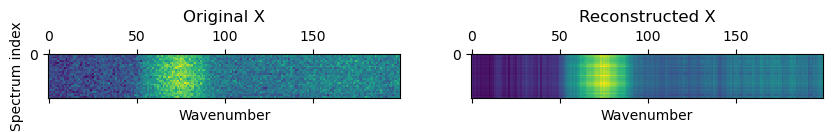

In [30]:
# Dataset Matrix
fig, axes = plt.subplots(1,2, figsize=(10,20))

# Original
ax = axes[0]
mappable = ax.matshow(X, cmap='viridis')
ax.set_xlabel('Wavenumber')
ax.set_ylabel('Spectrum index')
ax.set_title('Original X')
ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.grid(which='major', axis='both')
#plt.colorbar(mappable=mappable, ax=ax)


# Reconstructed
ax = axes[1]
mappable = ax.matshow(X_reconstructed, cmap='viridis')
ax.set_xlabel('Wavenumber')
ax.set_title('Reconstructed X')
ax.yaxis.set_major_locator(MultipleLocator(100))
#ax.grid(which='major', axis='both')
#plt.colorbar(mappable=mappable, ax=ax)

plt.show()